# Turner Lab M1 MPTP Dataset - NWB Usage Guide

**Dataset Overview:**
This dataset contains single-unit electrophysiology recordings from primary motor cortex (M1) of parkinsonian macaque monkeys performing flexion/extension motor tasks. The data investigates motor encoding deficits in MPTP-induced parkinsonism, comparing pyramidal tract neurons (PTNs) versus corticostriatal neurons (CSNs).

**Key Features:**
- **Single-unit recordings**: Spike times and waveforms from M1 neurons
- **Motor behavior**: Flexion/extension task with analog kinematics
- **Cell type identification**: Antidromic stimulation to classify PTNs vs CSNs
- **Disease model**: MPTP-treated parkinsonian macaque monkeys
- **Electrode mapping**: Systematic cortical penetrations with stereotactic coordinates

**Data Organization:**
- Each NWB file represents one recording session from one penetration depth
- Session IDs follow pattern: `{Animal}++{PreMPTP|PostMPTP}++Depth{depth_um}um++{YearMonthDay}`
- Example: `V++PostMPTP++Depth19180um++20000121` indicates monkey V, post-MPTP condition, 19.18mm depth, recorded Jan 21, 2000

## Loading NWB Files

For now, we'll demonstrate loading files locally. In the future, these will be available for streaming via DANDI.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from pynwb import NWBHDF5IO

# Example: Load a local NWB file
nwbfiles_directory = Path("/home/heberto/development/conversions/turner-lab-to-nwb/nwbfiles")
assert nwbfiles_directory.exists(), f"Directory {nwbfiles_directory} does not exist."
nwb_files = list(nwbfiles_directory.glob("*.nwb"))

if len(nwb_files) > 0:
    example_file = nwb_files[0]
    print(f"Loading example file: {example_file.name}")
    
    with NWBHDF5IO(str(example_file), 'r') as io:
        nwbfile = io.read()
        print(f"Session: {nwbfile.session_id}")
        print(f"Description: {nwbfile.session_description}")
        print(f"Subject: {nwbfile.subject.subject_id}")
        print(f"Start time: {nwbfile.session_start_time}")
        print(f"\nTemporal limitations: {nwbfile.notes}")
else:
    print("No NWB files found. Please run the conversion script first.")

Loading example file: V3217++PreMPTP++Depth20700um++19990708.nwb
Session: v3217.1
Description: 
Subject: unknown
Start time: 1999-07-08 00:00:00-04:00

Temporal limitations: Temporal data limitation: Recording dates are accurate from experimental logs, but precise session start times within each day are not available in source data. session_start_time is set to midnight (Pittsburgh timezone) with 2-hour systematic offsets for multiple sessions recorded on the same date, ordered by file sequence. All relative timing within each session (trials, spikes, stimulation) maintains original temporal accuracy. NOTE: Inter-trial intervals are not available in source data - trials are separated by fixed 3-second intervals for temporal organization purposes only and should not be interpreted as actual behavioral inter-trial timing.


## Electrode Configuration and Recording Setup

The dataset includes both recording and stimulation electrodes with detailed anatomical information.

In [3]:
# Examine electrode configuration
from pynwb import read_nwb

nwbfile = read_nwb(example_file)
electrodes_df = nwbfile.electrodes.to_dataframe()
print("Electrode Configuration:")
print(f"Total electrodes: {len(electrodes_df)}")
print(f"Recording electrodes: {len(electrodes_df[~electrodes_df['is_stimulation']])}")
print(f"Stimulation electrodes: {len(electrodes_df[electrodes_df['is_stimulation']])}")

print("\nRecording electrode details:")
recording_electrode = electrodes_df[~electrodes_df['is_stimulation']].iloc[0]
print(f"  Chamber coordinates: A/P={recording_electrode['chamber_grid_ap_mm']:.2f}mm, M/L={recording_electrode['chamber_grid_ml_mm']:.2f}mm")
print(f"  Insertion depth: {recording_electrode['chamber_insertion_depth_mm']:.2f}mm")
print(f"  Recording site index: {recording_electrode['recording_site_index']}")
print(f"  Recording session index: {recording_electrode['recording_session_index']}")

print("\nStimulation electrodes:")
stim_electrodes = electrodes_df[electrodes_df['is_stimulation']]
for _, electrode in stim_electrodes.iterrows():
    print(f"  {electrode['location']}: {electrode['stim_notes']}")

# Display electrode table
electrodes_df[['location', 'group_name', 'is_stimulation', 'chamber_grid_ap_mm', 'chamber_grid_ml_mm', 'chamber_insertion_depth_mm']]

Electrode Configuration:
Total electrodes: 6
Recording electrodes: 1
Stimulation electrodes: 5

Recording electrode details:
  Chamber coordinates: A/P=-3.00mm, M/L=-5.00mm
  Insertion depth: 20.70mm
  Recording site index: 32
  Recording session index: 17

Stimulation electrodes:
  Cerebral peduncle (pre-pontine): Ventral to substantia nigra, arm-responsive pre-pontine region
  Putamen (posterolateral): Electrode 1 of 3, posterolateral putamen for M1 CSN projections
  Putamen (posterolateral): Electrode 2 of 3, posterolateral putamen for M1 CSN projections
  Putamen (posterolateral): Electrode 3 of 3, posterolateral putamen for M1 CSN projections
  Ventrolateral thalamus: VL thalamus for thalamocortical projection identification


,location,group_name,is_stimulation,chamber_grid_ap_mm,chamber_grid_ml_mm,chamber_insertion_depth_mm
id,,,,,,
0,"Primary motor cortex (M1), area 4, arm area",ElectrodeGroupM1Recording,False,-3.0,-5.0,20.7
1,Cerebral peduncle (pre-pontine),ElectrodeGroupStimPeduncle,True,NaN,NaN,NaN
2,Putamen (posterolateral),ElectrodeGroupStimPutamen,True,NaN,NaN,NaN
3,Putamen (posterolateral),ElectrodeGroupStimPutamen,True,NaN,NaN,NaN
4,Putamen (posterolateral),ElectrodeGroupStimPutamen,True,NaN,NaN,NaN
5,Ventrolateral thalamus,ElectrodeGroupStimThalamus,True,NaN,NaN,NaN


## Trial Structure and Motor Behavior

First, let's examine the experimental trials which provide the temporal structure for all other analyses.

In [5]:
# Analyze trial structure
trials_df = nwbfile.trials.to_dataframe()
print(f"Number of trials: {len(trials_df)}")
print("\nTrial metadata columns:")
for col in trials_df.columns:
    print(f"  {col}")

# Display trials table
trials_df

Number of trials: 20

Trial metadata columns:
  start_time
  stop_time
  center_target_appearance_time
  lateral_target_appearance_time
  cursor_departure_time
  reward_time
  movement_type
  torque_perturbation_type
  torque_perturbation_onset_time
  derived_movement_onset_time
  derived_movement_end_time
  derived_peak_velocity
  derived_peak_velocity_time
  derived_movement_amplitude
  derived_end_position


,start_time,stop_time,center_target_appearance_time,lateral_target_appearance_time,cursor_departure_time,reward_time,movement_type,torque_perturbation_type,torque_perturbation_onset_time,derived_movement_onset_time,derived_movement_end_time,derived_peak_velocity,derived_peak_velocity_time,derived_movement_amplitude,derived_end_position
id,,,,,,,,,,,,,,,
0,0.000,9.432,2.712,7.464,7.868,8.728,extension,flexion,4.408,7.806,8.063,146.182921,7.925,-20.817339,-20.292940
1,12.432,21.986,14.623,19.837,20.168,21.269,flexion,flexion,16.319,20.143,20.438,123.120216,20.304,18.875539,20.270499
2,24.986,32.240,27.020,30.025,30.456,31.536,extension,none,NaN,30.394,30.651,150.004982,30.521,-21.312594,-21.363640
3,35.240,44.436,38.379,42.353,42.770,43.731,flexion,extension,40.075,42.700,42.959,161.206322,42.848,21.838341,21.364760
4,47.436,56.292,50.012,54.339,54.667,55.586,flexion,extension,51.708,54.596,54.858,151.614966,54.744,21.297847,20.724863
5,59.292,67.766,61.445,65.805,66.229,67.047,extension,flexion,63.153,66.167,66.416,139.964053,66.297,-18.981849,-19.105789
6,70.766,78.718,73.329,76.431,76.874,77.995,extension,none,NaN,76.796,77.065,135.478743,76.935,-19.783690,-18.798940
7,81.718,90.964,84.516,88.993,89.368,90.239,flexion,flexion,86.212,89.313,89.589,136.126818,89.464,19.820400,20.418560
8,93.964,102.838,96.850,100.801,101.203,102.130,flexion,extension,98.547,101.148,101.419,143.487096,101.298,20.767747,21.265160


## Single-Unit Activity Analysis

Now let's examine the single-unit spike data and how it relates to the trial structure.

In [6]:
# Examine units table
units_df = nwbfile.units.to_dataframe()
units_df

,neuron_projection_type,antidromic_stimulation_sites,antidromic_latency_ms,antidromic_threshold,antidromic_latency_2_ms,antidromic_threshold_2,sensory_region,sensory_detail,spike_times,electrodes
id,,,,,,,,,,
0,corticostriatal_neuron,posterolateral_striatum,3.1,350.0,NaN,NaN,no_response,selective finger release,"[1.685, 2.563, 4.93, 5.081, 5.435, 5.482, 7.23...",locatio...


## Trialized Spike Analysis

Let's analyze spikes within the context of behavioral trials.

Unit 0 analysis:
  Total spikes: 557
  Recording duration: 229.71 seconds
  Mean firing rate: 2.42 Hz


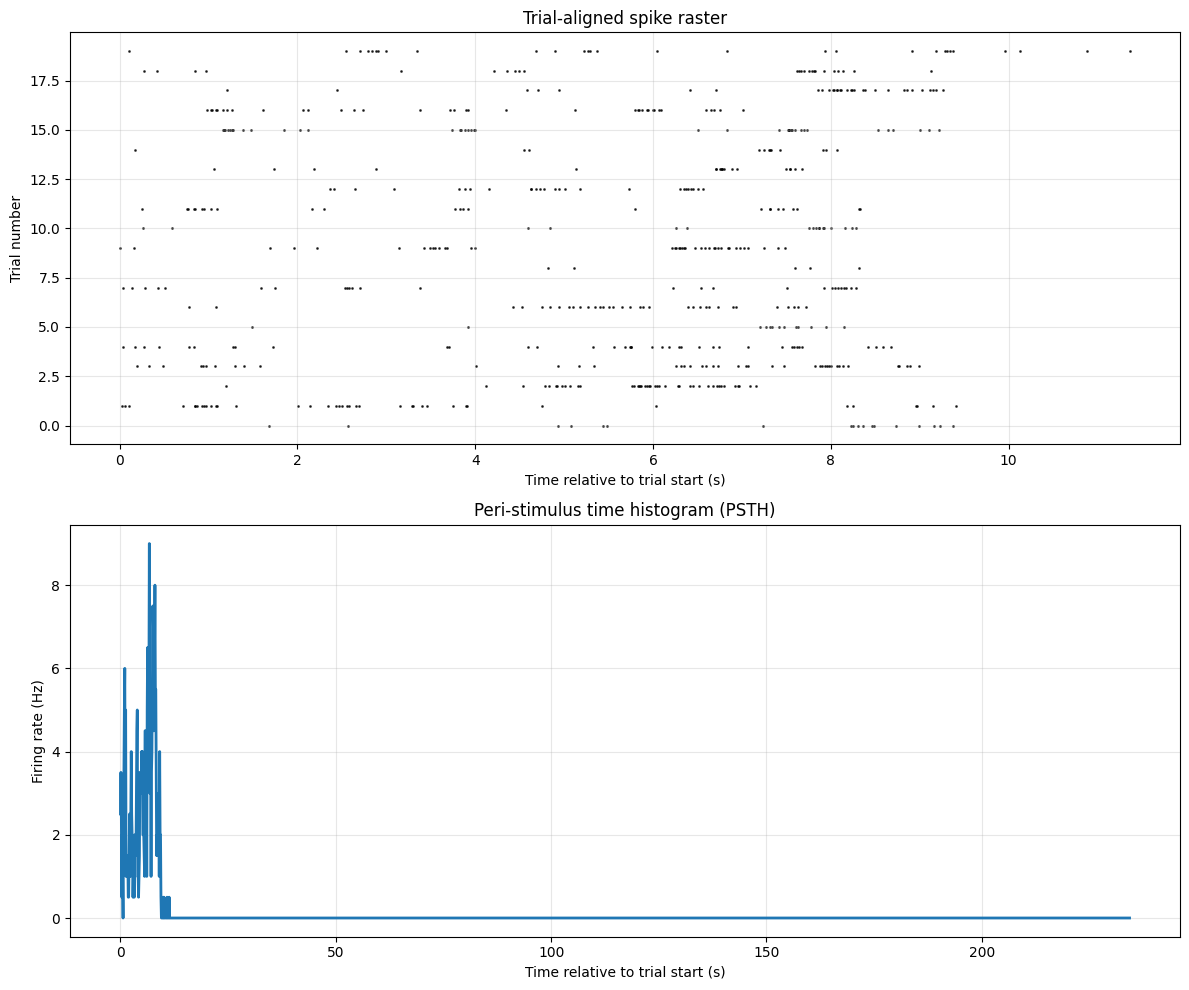

\nTrialized analysis:
  Trials with spikes: 20/20
  Mean spikes per trial: 27.85


In [7]:
# Trialized spike analysis
unit_id = 0
spike_times = nwbfile.units['spike_times'][unit_id]

print(f"Unit {unit_id} analysis:")
print(f"  Total spikes: {len(spike_times)}")
print(f"  Recording duration: {spike_times[-1] - spike_times[0]:.2f} seconds")
print(f"  Mean firing rate: {len(spike_times) / (spike_times[-1] - spike_times[0]):.2f} Hz")

# Create trial-aligned spike raster
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Trial-aligned spike raster
trial_spikes = []
for trial_idx, trial in trials_df.iterrows():
    trial_start = trial['start_time']
    trial_stop = trial['stop_time']
    
    # Find spikes within this trial
    trial_spike_times = spike_times[(spike_times >= trial_start) & (spike_times <= trial_stop)]
    
    # Convert to trial-relative times
    relative_spike_times = trial_spike_times - trial_start
    trial_spikes.append(relative_spike_times)
    
    # Plot spikes for this trial
    if len(relative_spike_times) > 0:
        ax1.scatter(relative_spike_times, np.full(len(relative_spike_times), trial_idx), 
                   s=1, color='black', alpha=0.7)

ax1.set_xlabel('Time relative to trial start (s)')
ax1.set_ylabel('Trial number')
ax1.set_title('Trial-aligned spike raster')
ax1.grid(True, alpha=0.3)

# PSTH across trials
# Bin spikes relative to trial start
bin_size = 0.1  # 100ms bins
max_trial_duration = trials_df['stop_time'].max() - trials_df['start_time'].min()
bins = np.arange(0, max_trial_duration + bin_size, bin_size)

# Collect all trial-relative spike times
all_relative_spikes = np.concatenate([spikes for spikes in trial_spikes if len(spikes) > 0])

if len(all_relative_spikes) > 0:
    counts, _ = np.histogram(all_relative_spikes, bins=bins)
    firing_rate = counts / (bin_size * len(trials_df))  # Average across trials
    
    ax2.plot(bins[:-1], firing_rate, linewidth=2)
    ax2.set_xlabel('Time relative to trial start (s)')
    ax2.set_ylabel('Firing rate (Hz)')
    ax2.set_title('Peri-stimulus time histogram (PSTH)')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\\nTrialized analysis:")
print(f"  Trials with spikes: {sum(1 for spikes in trial_spikes if len(spikes) > 0)}/{len(trials_df)}")
print(f"  Mean spikes per trial: {np.mean([len(spikes) for spikes in trial_spikes]):.2f}")

## Trialized Kinematic Analysis (TimeSeriesElbowVelocity)

Now let's examine how the kinematic data aligns with trials.

In [8]:
# Trialized kinematic analysis
# Find TimeSeriesElbowVelocity
elbow_velocity_series = nwbfile.acquisition['TimeSeriesElbowVelocity']

print(f"Kinematic data: {elbow_velocity_series.name}")
print(f"  Description: {elbow_velocity_series.description}")
print(f"  Data shape: {elbow_velocity_series.data.shape}")
print(f"  Sampling rate: {elbow_velocity_series.rate} Hz")
print(f"  Duration: {elbow_velocity_series.data.shape[0] / elbow_velocity_series.rate:.2f} seconds")

# Extract trial-aligned kinematic data
kinematic_data = elbow_velocity_series.data[:]
sampling_rate = elbow_velocity_series.rate

# Plot trial-aligned kinematics
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

trial_kinematics = []
for trial_idx, trial in trials_df.iterrows():
    trial_start = trial['start_time']
    trial_stop = trial['stop_time']
    
    # Convert trial times to sample indices
    start_sample = int(trial_start * sampling_rate)
    stop_sample = int(trial_stop * sampling_rate)
    
    # Extract kinematic data for this trial
    trial_data = kinematic_data[start_sample:stop_sample]
    trial_time = np.arange(len(trial_data)) / sampling_rate
    
    trial_kinematics.append(trial_data)
    
    # Plot individual trial (show first 10 trials)
    if trial_idx < 10:
        ax1.plot(trial_time, trial_data, alpha=0.7, linewidth=1, label=f'Trial {trial_idx+1}')

ax1.set_xlabel('Time relative to trial start (s)')
ax1.set_ylabel('Elbow Velocity')
ax1.set_title('Trial-aligned Elbow Velocity (first 10 trials)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Average across trials
# Find minimum trial length for alignment
min_trial_length = min(len(trial_data) for trial_data in trial_kinematics)

# Truncate all trials to minimum length and average
aligned_trials = np.array([trial_data[:min_trial_length] for trial_data in trial_kinematics])
mean_kinematic = np.mean(aligned_trials, axis=0)
std_kinematic = np.std(aligned_trials, axis=0)

time_axis = np.arange(min_trial_length) / sampling_rate

ax2.plot(time_axis, mean_kinematic, 'b-', linewidth=2, label='Mean')
ax2.fill_between(time_axis, 
                mean_kinematic - std_kinematic, 
                mean_kinematic + std_kinematic, 
                alpha=0.3, color='blue', label='±1 SD')
ax2.set_xlabel('Time relative to trial start (s)')
ax2.set_ylabel('Elbow Velocity')
ax2.set_title('Average trial-aligned Elbow Velocity')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\\nTrialized kinematic analysis:")
print(f"  Number of trials: {len(trial_kinematics)}")
print(f"  Average trial duration: {np.mean([len(trial)/sampling_rate for trial in trial_kinematics]):.2f} seconds")
print(f"  Kinematic range: {np.min(kinematic_data):.2f} to {np.max(kinematic_data):.2f}")

KeyError: 'TimeSeriesElbowVelocity'

## Waveform Analysis

Examine spike waveform characteristics for unit classification.

In [ ]:
# Analyze spike waveforms
unit_id = 0

# Get waveform data
waveform_mean = nwbfile.units['waveform_mean'][unit_id]
waveform_sd = nwbfile.units['waveform_sd'][unit_id]

# Create time axis (20kHz sampling, 1.6ms window)
sampling_rate = 20000  # Hz
n_samples = len(waveform_mean)
time_axis = np.arange(n_samples) / sampling_rate * 1000  # Convert to milliseconds

# Plot waveform with error bars
plt.figure(figsize=(10, 6))
plt.plot(time_axis, waveform_mean, 'b-', linewidth=2, label='Mean waveform')
plt.fill_between(time_axis, 
                    waveform_mean - waveform_sd, 
                    waveform_mean + waveform_sd, 
                    alpha=0.3, color='blue', label='±1 SD')

plt.xlabel('Time (ms)')
plt.ylabel('Voltage (μV)')
plt.title(f'Unit {unit_id} - Mean Spike Waveform')
plt.legend()
plt.grid(True, alpha=0.3)

# Add waveform characteristics
duration = nwbfile.units['waveform_duration_ms'][unit_id]
cell_type = nwbfile.units['cell_type'][unit_id]

plt.text(0.7, 0.95, f'Duration: {duration:.2f} ms', 
        transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.text(0.7, 0.85, f'Cell type: {cell_type}', 
        transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## Antidromic Stimulation Analysis

Examine the antidromic stimulation data used for cell type identification.

In [ ]:
# Analyze antidromic stimulation data
antidromic_module = nwbfile.processing['antidromic_identification']
print(f"Antidromic identification module found")
print(f"Description: {antidromic_module.description}")

# Find stimulation and response series
stim_series = []
response_series = []

for name, obj in antidromic_module.data_interfaces.items():
    if 'Stimulation' in name:
        stim_series.append((name, obj))
    elif 'Response' in name:
        response_series.append((name, obj))

print(f"\\nFound {len(stim_series)} stimulation series and {len(response_series)} response series")

# Plot one stimulation-response pair
stim_name, stim_data = stim_series[0]
resp_name, resp_data = response_series[0]

print(f"\\nAnalyzing: {stim_name} and {resp_name}")

# Get a small segment for visualization (first 5 sweeps)
n_samples_per_sweep = 1000  # 50ms at 20kHz
n_sweeps_to_plot = 5

stim_segment = stim_data.data[:n_samples_per_sweep * n_sweeps_to_plot]
resp_segment = resp_data.data[:n_samples_per_sweep * n_sweeps_to_plot]
time_segment = stim_data.timestamps[:n_samples_per_sweep * n_sweeps_to_plot]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot stimulation current
ax1.plot(time_segment, stim_segment * 1e6, 'r-', linewidth=1)  # Convert to μA
ax1.set_ylabel('Stimulation Current (μA)')
ax1.set_title(f'{stim_name} - First {n_sweeps_to_plot} sweeps')
ax1.grid(True, alpha=0.3)

# Plot neural response
ax2.plot(time_segment, resp_segment * 1e6, 'b-', linewidth=1)  # Convert to μV
ax2.set_ylabel('Neural Response (μV)')
ax2.set_xlabel('Time (s)')
ax2.set_title(f'{resp_name} - First {n_sweeps_to_plot} sweeps')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Stimulation data shape: {stim_data.data.shape}")
print(f"Response data shape: {resp_data.data.shape}")
print(f"Stimulation placed at: {stim_data.timestamps[0]:.1f} seconds after session start")

## Cross-Data Analysis: Spike-Triggered Averages

Demonstrate how to combine multiple data streams for analysis.

In [ ]:
# Create spike-triggered average of kinematic data
unit_id = 0
spike_times = nwbfile.units['spike_times'][unit_id]

# Get kinematic data
kinematic_series = nwbfile.acquisition['TimeSeriesElbowVelocity']

# Parameters for spike-triggered average
window_size = 0.5  # ±500ms around each spike
sampling_rate = kinematic_series.rate
window_samples = int(window_size * sampling_rate)

# Get kinematic data
kinematic_data = kinematic_series.data[:]

# Extract windows around spikes
sta_windows = []

for spike_time in spike_times:
    spike_sample = int(spike_time * sampling_rate)
    
    # Check if window fits within data
    if (spike_sample - window_samples >= 0 and 
        spike_sample + window_samples < len(kinematic_data)):
        
        window = kinematic_data[spike_sample - window_samples:spike_sample + window_samples + 1]
        sta_windows.append(window)

sta_windows = np.array(sta_windows)

# Calculate mean and standard error
sta_mean = np.mean(sta_windows, axis=0)
sta_sem = np.std(sta_windows, axis=0) / np.sqrt(len(sta_windows))

# Create time axis
time_axis = np.linspace(-window_size, window_size, len(sta_mean))

# Plot spike-triggered average
plt.figure(figsize=(10, 6))
plt.plot(time_axis, sta_mean, 'b-', linewidth=2, label='Mean')
plt.fill_between(time_axis, 
               sta_mean - sta_sem, 
               sta_mean + sta_sem, 
               alpha=0.3, color='blue', label='±SEM')

plt.axvline(0, color='red', linestyle='--', alpha=0.7, label='Spike time')
plt.xlabel('Time relative to spike (s)')
plt.ylabel('Elbow Velocity')
plt.title(f'Spike-Triggered Average (Unit {unit_id}, n={len(sta_windows)} spikes)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Analyzed {len(sta_windows)} spikes out of {len(spike_times)} total")

## Summary

This notebook demonstrates the key data types and analysis approaches for the Turner Lab M1 MPTP dataset:

**Data Types Covered:**
1. **Electrode configuration**: Recording and stimulation electrode setup with anatomical coordinates
2. **Single-unit activity**: Spike times, waveforms, and cell type classification
3. **Motor behavior**: Trial structure and analog kinematic recordings
4. **Antidromic stimulation**: Electrical stimulation protocols for cell type identification
5. **Cross-modal analysis**: Combining spike times with kinematic data

**Key Features:**
- All temporal data maintains original accuracy within each session
- Systematic electrode mapping with chamber-relative coordinates
- Cell type identification through antidromic stimulation
- Motor task data for studying parkinsonian deficits
- Rich metadata for experimental context

**Temporal Limitations (Important):**
- Session start times are set to midnight with systematic offsets for same-day recordings
- Inter-trial intervals use fixed 3-second separation (not original behavioral timing)
- All relative timing within sessions maintains original accuracy

This standardized NWB format enables reproducible analysis of motor cortex function in parkinsonian primates and facilitates comparison with other neurophysiology datasets.